# Flights in the United States
## by Benoît Courty

## Preliminary Wrangling

This dataset reports flights in the United States, including carriers, arrival and departure delays, and reasons for delays, from 1987 to 2008.

In [14]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
def pv(variable):
    if(len(variable)>1): print(variable, ":", eval(variable))

In [15]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

### Downloading the datasets

The dataset consist of a file per year.

We will look over a list of availiable years and download the files.

Source : 
http://stat-computing.org/dataexpo/2009/1987.csv.bz2

In [16]:
import os
import requests
folder_name = "./"

def download_files(folder_name):
    years = []
    for year in range(1987, 2008+1):
        years.append(year)  
        url = "http://stat-computing.org/dataexpo/2009/" + str(year) + ".csv.bz2"
        filename = url.split('/')[-1]
        response = requests.get(url)
        with open(os.path.join(folder_name, filename), mode='wb') as file:
            file.write(response.content)
    print("Files retreived !")
    return years

years = []
#years = download_files(folder_name)

[]


Now, we have our dataset, let's load it.

### Loading the dataset

I've writen the code to merge all the data, but it's too big for my computer.
If needed later I could sample data, or compute some agregate.

I will begin by using only 2008 as it is the more recent datas.

In [17]:
import pandas as pd

years = ['2008']
df = pd.DataFrame()
for year in years:
    datafilename = folder_name + year + '.csv.bz2'
    print(datafilename)
    df_temp = pd.read_csv(datafilename)
    df = pd.concat([df, df_temp])

./2008.csv.bz2


Get a rapid overview of it.

In [163]:
# df.head(3)
# df.tail(3)
# df.columns
# df.dtypes
# df.describe()
# df.info()

It's a huge Dataset : 7 009 728 entries with 29 columns.

At first look it seems clean and tidy.

Let's explore categorical variable with less than 15 unique values.

In [164]:
def explore_value(df):
    to_be_removed = []
    columns = df.columns
    for column in columns:
        nb_unique_values = eval('df.' + column + '.nunique()')
        #print("Distinct values in", column, ":", nb_unique_values)
        if nb_unique_values > 15:
            to_be_removed.append(column)
    columns_redux = [item for item in columns if item not in to_be_removed ]
    
    #print(columns_redux)
    for column in columns_redux:
        
        code = 'df.' + column + '.value_counts()'
        print("Distinct values in", column, ':', code)
        print(eval(code))

explore_value(df)

Distinct values in Month : df.Month.value_counts()
7     627931
3     616090
8     612279
6     608665
5     606293
1     605765
4     598126
2     569236
10    556205
12    544958
9     540908
11    523272
Name: Month, dtype: int64
Distinct values in DayOfWeek : df.DayOfWeek.value_counts()
3    1039665
1    1036201
5    1035166
4    1032224
2    1032049
7     976887
6     857536
Name: DayOfWeek, dtype: int64
Distinct values in Cancelled : df.Cancelled.value_counts()
0    6872294
1     137434
Name: Cancelled, dtype: int64
Distinct values in CancellationCode : df.CancellationCode.value_counts()
B    54904
A    54330
C    28188
D       12
Name: CancellationCode, dtype: int64
Distinct values in Diverted : df.Diverted.value_counts()
0    6992463
1      17265
Name: Diverted, dtype: int64
Distinct values in ArrStatus : df.ArrStatus.value_counts()
On Time         4076441
Early            976234
Small Delay      900956
Medium Delay     643909
Very late        257489
Cancelled        137434
Div

Only 12 Security cancellation (D) in one year. We will have miss it if we have used a sample.

Check if it will be a good idea to merge CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay.

In [162]:
df.query("CarrierDelay > 0 and WeatherDelay > 0")[['CarrierDelay', 'WeatherDelay']][:3]

,CarrierDelay,WeatherDelay
98551,12.0,8.0
101614,224.0,120.0
303687,2.0,61.0


The delay could exist for more than one category, so we will not merge them.

## Dropping unnessary columns

I will drop some columns as I think I will not need them.

In [21]:
# Drop unused columns
df.drop(['Year', 'TaxiIn', 'TaxiOut', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime'], axis=1, inplace=True)

## Adding external data

We saw that the dataset contain only codes for airports and carriers, as we will display it, we are going to retreive the label for them.

I get it from  http://stat-computing.org/dataexpo/2009/supplemental-data.html :
- For City / Airport : http://stat-computing.org/dataexpo/2009/airports.csv
- For Carrier : http://stat-computing.org/dataexpo/2009/carriers.csv


In [22]:
def download(url):
    filename = url.split('/')[-1]
    response = requests.get(url)
    with open(os.path.join(folder_name, filename), mode='wb') as file:
        file.write(response.content)
    return filename
# download("http://stat-computing.org/dataexpo/2009/airports.csv")
# download("http://stat-computing.org/dataexpo/2009/carriers.csv")

In [23]:
df_airports = pd.read_csv("airports.csv")
df_carriers = pd.read_csv("carriers.csv")

In [166]:
# df_airports.head(3)
# df_carriers.head(3)

Now we have the data, let's merge it with our dataset.

In [25]:
# Add Origin City name
df_tmp = df.merge(df_airports[['iata', 'city', 'state', 'lat', 'long']], how='left', left_on='Origin', right_on='iata')
df_tmp.drop('iata', axis=1, inplace=True)
df_tmp.rename(columns={'city':'OriginCity', 'state':'OriginState', 'lat':'OriginLat', 'long':'OriginLong'}, inplace=True)

# Add Destination City name
df_tmp = df_tmp.merge(df_airports[['iata', 'city', 'state', 'lat', 'long']], how='left', left_on='Dest', right_on='iata')
df_tmp.drop('iata', axis=1, inplace=True)
df_tmp.rename(columns={'city':'DestCity', 'state':'DestState', 'lat':'DestLat', 'long':'DestLong'}, inplace=True)

# Add Carrier Name
df_tmp = df_tmp.merge(df_carriers[['Code', 'Description']], how='left', left_on='UniqueCarrier', right_on='Code')
df_tmp.drop('Code', axis=1, inplace=True)
df_tmp.rename(columns={'Description':'CarrierName'}, inplace=True)

We still have a problem with state code instead of state name, let's change it :

In [27]:
#filename = download("https://github.com/jasonong/List-of-US-States/raw/master/states.csv")
filename = "states.csv"
df_states = pd.read_csv(filename)

df_tmp = df_tmp.merge(df_states, how='left', left_on='OriginState', right_on='Abbreviation')
df_tmp.drop('Abbreviation', axis=1, inplace=True)
df_tmp.rename(columns={'State':'OriginStateName'}, inplace=True)


df_tmp = df_tmp.merge(df_states, how='left', left_on='DestState', right_on='Abbreviation')
df_tmp.drop('Abbreviation', axis=1, inplace=True)
df_tmp.rename(columns={'State':'DestStateName'}, inplace=True)


Check the data :

In [31]:
df_tmp[['OriginCity',
       'OriginState', 'OriginLat', 'OriginLong', 'DestCity', 'DestState',
       'DestLat', 'DestLong', 'CarrierName', 'OriginStateName',
       'DestStateName']].head(3)

,OriginCity,OriginState,OriginLat,OriginLong,DestCity,DestState,DestLat,DestLong,CarrierName,OriginStateName,DestStateName
0,Chantilly,VA,38.944532,-77.455810,Tampa,FL,27.975472,-82.533250,Southwest Airlines Co.,Virginia,Florida
1,Chantilly,VA,38.944532,-77.455810,Tampa,FL,27.975472,-82.533250,Southwest Airlines Co.,Virginia,Florida
2,Indianapolis,IN,39.717329,-86.294384,Baltimore,MD,39.175402,-76.668198,Southwest Airlines Co.,Indiana,Maryland


Great we know have label better to understand, so let's replace main dataframe with our new one.

In [32]:
df = df_tmp;

We also have to rename a carrier that is too long :

In [245]:
df.CarrierName.replace('US Airways Inc. (Merged with America West 9/05. Reporting for both starting 10/07.)', 'US Airways', inplace=True);

### What is the structure of your dataset?

As stated on http://stat-computing.org/dataexpo/2009/ :
The data consists of flight arrival and departure details for all commercial flights within the USA, from October 1987 to April 2008. This is a large dataset: there are nearly 120 million records in total, and takes up 1.6 gigabytes of space compressed and 12 gigabytes when uncompressed. 

The data come from the US Bureau of Transportation Statistics.

The dataset is a series of CSV containing one line per flight in the US. With 29 informations about the fligth : origin, destination, date, reason of delay, take off time... Mainly numerical. Some of them are continuous (delay) and others categorical (month).

It's only the internal US flights (domestic), not the international flight arriving/living the US.

It's already a huge file with seven millions of lines just for 2008 year.

The file are compressed in BZ2 and it was an happy surprise that Pandas could directly load it.

We are also provided with a description of every columns : https://www.transtats.bts.gov/Fields.asp?Table_ID=236

### Information about the data


    If Cancelled==1 it mean the flight has been canceled
    If Diverted==1 it mean the flight has been delayed

    Variable descriptions from http://stat-computing.org/dataexpo/2009/the-data.html
        Name 	Description
    1 	Year 	1987-2008
    2 	Month 	1-12
    3 	DayofMonth 	1-31
    4 	DayOfWeek 	1 (Monday) - 7 (Sunday)
    5 	DepTime 	actual departure time (local, hhmm)
    6 	CRSDepTime 	scheduled departure time (local, hhmm)
    7 	ArrTime 	actual arrival time (local, hhmm)
    8 	CRSArrTime 	scheduled arrival time (local, hhmm)
    9 	UniqueCarrier 	unique carrier code
    10 	FlightNum 	flight number
    11 	TailNum 	plane tail number
    12 	ActualElapsedTime 	in minutes
    13 	CRSElapsedTime 	in minutes
    14 	AirTime 	in minutes
    15 	ArrDelay 	arrival delay, in minutes
    16 	DepDelay 	departure delay, in minutes
    17 	Origin 	origin IATA airport code
    18 	Dest 	destination IATA airport code
    19 	Distance 	in miles
    20 	TaxiIn 	taxi in time, in minutes
    21 	TaxiOut 	taxi out time in minutes
    22 	Cancelled 	was the flight cancelled?
    23 	CancellationCode 	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
    24 	Diverted 	1 = yes, 0 = no
    25 	CarrierDelay 	in minutes
    26 	WeatherDelay 	in minutes
    27 	NASDelay 	in minutes
    28 	SecurityDelay 	in minutes
    29 	LateAircraftDelay 	in minutes


### What is/are the main feature(s) of interest in your dataset?

We could use this dataset for many things, but I will focus on exploring the flight delay.

So the main feature will be the ArrDelay columns that containt the difference in minutes between planed arrival time and actual arrival time.

I will also explore cancelled and diverted flight as it is an inconvenient for passengers.

> Are there certain destination or arrival cities that are home to more delays or cancellations?

- Evolution of delay type over time
- Airport that are more subject to delay ?
- More security delay after 11 september 2001 ?
- What root cause lead to more delay in terme of time.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Well, almost all column could have a corelation with delay. For exemple maybe night flight have more delay, or sunday flight, on february flight, or flights from a specific carrier or specific airport...

We even have the Tail Number (the ID of the plane) to check if a specific aircraft has more delay than others.

I  will quickly have look to correlation, then investigate the one that seems more revelant.

We have many years so we could also look at changes between years.

'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'


Delay cause
Airport
Carrier
Delay time
Day of week
Month in case of 


Build categorical variable for :
- on_time
- Small_wait
- Medium_Wait
- Huge Wait
- delayed
- diverted
- canceled


## Tidy

I was thinking of merging CarrierDelay, WeatherDelay, NASDelay, SecurityDelay and LateAircraftDelay in one column, with another with the reason.

But there could be many delay for the same flight.

Time of day like CRSDepTime are in hhmm format. That's not cleen because we can't make reliable operation on it. If we want to compute difference in time to get the delay for exemple.

1905 - 1855 = 50 but it's only 10 minutes

To get it clean it will be best to convert it in minutes. Let's do it.


In [ ]:
#df_test = df_late.sample(frac=0.01, replace=False, random_state=1).query("ArrDelay > 10 and ArrDelay < 500 and Distance < 2000")
#pv('df_test.shape')

def only_hour(row):
    # Fill with zero to always have 4 digits
    hour = str(row['CRSDepTime']).zfill(4)
    # Keep only the first two caracter
    hour = int(hour[:2])
    return hour

df['CRSDepTimeHour'] = df.apply(only_hour, axis=1)

In [200]:
df.loc[[6863908,686398]]

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,DestLat,DestLong,CarrierName,OriginStateName,DestStateName,ArrStatus,ArrStatus_light,CancellationReason,Season,CRSDepTimeHour
6863908,12,1,1,48.0,50,619.0,553,NW,774,N584NW,...,44.880547,-93.216922,Northwest Airlines Inc.,Nevada,Minnesota,Small Delay,Delayed,NaN,Winter,0
686398,2,27,3,1507.0,1450,1626.0,1615,WN,2011,N354SW,...,39.297605,-94.713906,Southwest Airlines Co.,Illinois,Missouri,Small Delay,Delayed,NaN,Winter,14


It work fine.

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

In [34]:
pv("df['ArrDelay'].max()")
pv("df['ArrDelay'].min()")

df['ArrDelay'].max() : 2461.0
df['ArrDelay'].min() : -519.0


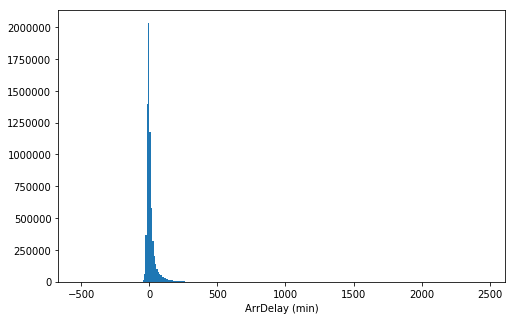

In [35]:
binsize = 10
bins = np.arange(df['ArrDelay'].min(), df['ArrDelay'].max()+binsize, binsize);
#print(bins)
plt.figure(figsize=[8, 5]);
plt.hist(data = df[np.isfinite(df['ArrDelay'])], x = 'ArrDelay', bins = bins);

plt.xlabel('ArrDelay (min)');
plt.show();


Huge spike aroud zero, so let's zoom around 0.

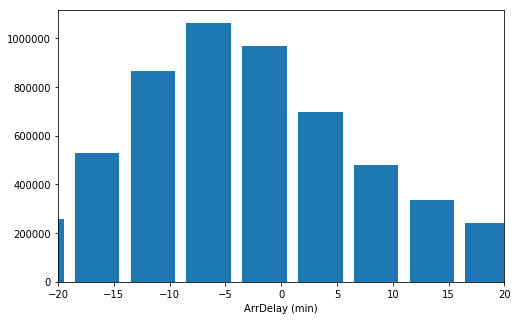

In [36]:
# Histogram plot
binsize = 5
bins = np.arange(df['ArrDelay'].min(), df['ArrDelay'].max()+binsize, binsize);
#print(bins)
plt.figure(figsize=[8, 5]);
plt.hist(data = df[np.isfinite(df['ArrDelay'])], x = 'ArrDelay', bins = bins, rwidth=0.8);
plt.xlabel('ArrDelay (min)');
plt.xticks(range(-30,30, binsize))
axes = plt.gca()
axes.set_xlim([-20,20])
plt.show();

The majority of planes landed early than expected.

There probably is a good reason for that, it's an interresting question to ask to a professional.


We first saw that the ArrDelay is right skewed with a slope with long tail that's look like a Landau distribution. https://en.wikipedia.org/wiki/Landau_distribution

So let's have a look to the ArrDelay at log scale.

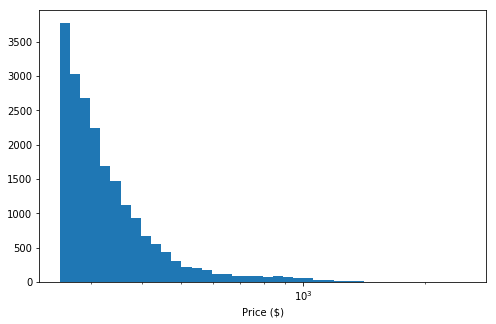

In [37]:

# there's a long tail in the distribution, so let's put it on a log scale instead
log_binsize = 0.025
bins = 10 ** np.arange(2.4, np.log10(df['ArrDelay'].max())+log_binsize, log_binsize)

# histogram on log scale. 
# Use non-equal bin sizes, such that they look equal on log scale.
# https://stackoverflow.com/questions/47850202/plotting-a-histogram-on-a-log-scale-with-matplotlib?rq=1
# logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

plt.figure(figsize=[8, 5]);
plt.hist(data = df[np.isfinite(df['ArrDelay'])], x = 'ArrDelay', bins = bins);
plt.xscale('log');
#plt.xticks([500, 1e3, 2e3], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Price ($)');
plt.show();


Even at log scale, the delay time seems to derease rapidely.

The distribution still have the same shape. With many short delay and few long delay.

It's not surprising as it is what we have expected.

So let's have a look at huge delay to saw what they look like :

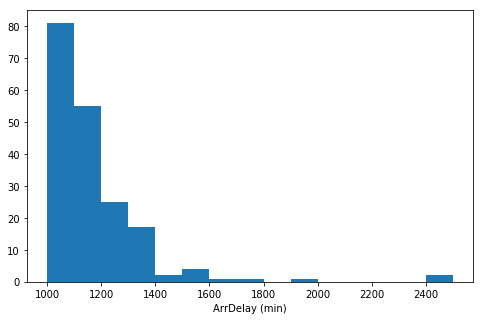

In [38]:
min_delay = 1000
df_hight_delay = df[np.isfinite(df['ArrDelay'])].query("ArrDelay > @min_delay")

binsize = 100
bins = np.arange(min_delay, df_hight_delay['ArrDelay'].max()+binsize, binsize);
plt.figure(figsize=[8, 5]);
plt.hist(data = df_hight_delay, x = 'ArrDelay', bins = bins);
plt.xlabel('ArrDelay (min)');
plt.show();


In [39]:
24*60
1800/60/24


1440

1.25

In [40]:
df[np.isfinite(df['ArrDelay'])].query("ArrDelay > 1200")[['Month', 'CRSDepTime', 'DepTime',
       'DepDelay',
       'CRSArrTime','ArrTime', 'ArrDelay', 'UniqueCarrier',  
        'Origin',  
       ]].head(3)

,Month,CRSDepTime,DepTime,DepDelay,CRSArrTime,ArrTime,ArrDelay,UniqueCarrier,Origin
503727,1,1930,1805.0,1355.0,2215,2052.0,1357.0,AA,DEN
527950,1,1045,800.0,1275.0,1327,1452.0,1525.0,AA,EGE
996512,2,1420,1257.0,1357.0,1650,1527.0,1357.0,MQ,VPS


In [41]:
# df[np.isfinite(df['ArrDelay'])].query("ActualElapsedTime - CRSElapsedTime > 1500 ")[['Month', 'DepTime', 'CRSDepTime',
#        'ArrTime', 'CRSArrTime', 'UniqueCarrier',  
#        'ArrDelay',
#        'DepDelay', 'Origin',  
#        ]]

The hight delay flight seems real. But some of them are strange like the flight who take off with a small delay but arrived with a huge delay of many hours.
For exemple, it's impossible for a plane to flight 18 hours when only 76 minutes was expected at take off.

So we could supposed that the plane have landed on an another airport before going to the final airport.

Another strange behaviour at first look is when real departure time are before planed but with a huge positive delay : it means the plane has take off the day after it was expected.

I have found strange exemple but I think we could keep them because we have a huge dataset and the values are in an acceptable range.

In [42]:
flights_count = df.shape[0]
late_count = df[df['ArrDelay'] > 5].shape[0]
pv('flights_count')
pv('late_count')
pv('late_count/flights_count')

flights_count : 7009728
late_count : 2283048
late_count/flights_count : 0.32569708838916434


In [43]:
# 'Cancelled', 'CancellationCode', 'Diverted'
# Thanks to https://stackoverflow.com/questions/32633977/how-to-create-categorical-variable-based-on-a-numerical-variable

# Set the categorical variable values
arr_status = ['Unknown', 'Early', 'On Time', 'Small Delay',
              'Medium Delay' ,'Very late', 'Diverted', 'Cancelled']
# Set default value
df['ArrStatus'] = 'Unknown';
pd.Categorical(df.ArrStatus, categories=arr_status, ordered=True);
# Cancelled Flight
df.loc[(df['Cancelled'] == 1) , 'ArrStatus'] = 'Cancelled'
#df['ArrStatus'].value_counts()
# Cancelled Flight
df.loc[(df['Diverted'] == 1) , 'ArrStatus'] = 'Diverted'
#df['ArrStatus'].value_counts()
df.loc[(df['ArrDelay'] <= -15) , 'ArrStatus'] = 'Early'
df.loc[(df['ArrDelay'] > -15) , 'ArrStatus'] = 'On Time'
df.loc[(df['ArrDelay'] > 10) , 'ArrStatus'] = 'Small Delay'
df.loc[(df['ArrDelay'] > 30) , 'ArrStatus'] = 'Medium Delay'
df.loc[(df['ArrDelay'] > 90) , 'ArrStatus'] = 'Very late'
df['ArrStatus'].value_counts()
# Elegant solution but work only for value separation
# bins=[-float('Inf'),-15, 5, 30, 65, float('Inf')]
# df['ArrStatus'] = pd.cut(df['ArrDelay'], bins, labels=['Early', 'On Time', 'Small Delay', 'Medium Delay' ,'Very late'])



[Unknown, Unknown, Unknown, Unknown, Unknown, ..., Unknown, Unknown, Unknown, Unknown, Unknown]
Length: 7009728
Categories (8, object): [Unknown < Early < On Time < Small Delay < Medium Delay < Very late < Diverted < Cancelled]

On Time         4076441
Early            976234
Small Delay      900956
Medium Delay     643909
Very late        257489
Cancelled        137434
Diverted          17265
Name: ArrStatus, dtype: int64

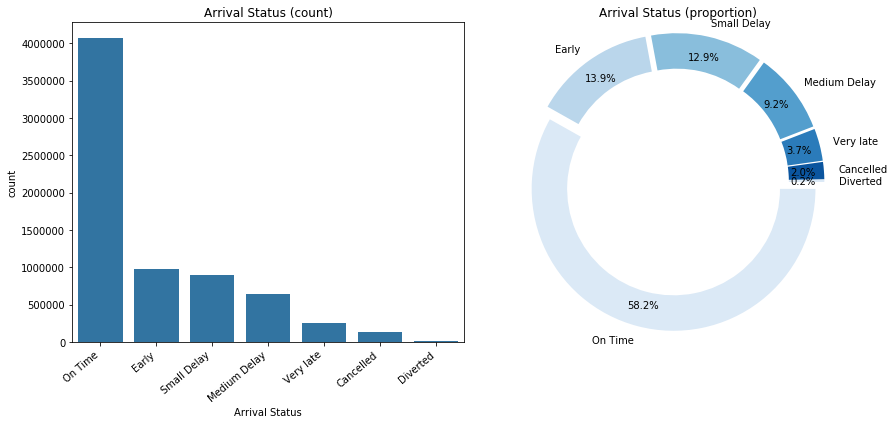

In [44]:
base_color = sns.color_palette()[0]
#sns.palplot(sns.color_palette("Blues"))

f,ax=plt.subplots(1,2,figsize=(13,6));
sns.countplot('ArrStatus',order = df['ArrStatus'].value_counts().index, data=df,ax=ax[0],
             color = base_color);
#plt.xticks(rotation = 90)
# Thanks to https://stackoverflow.com/questions/42528921/how-to-prevent-overlapping-x-axis-labels-in-sns-countplot
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Arrival Status (count)');
ax[0].set_xlabel('Arrival Status');

# Thanks to https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
#explosion
explode = []
for i in range(len(df['ArrStatus'].value_counts())):
    explode.append(0.05)

df['ArrStatus'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],
                                       wedgeprops = {'width' : 0.25},
                                       startangle = 0,
                                       counterclock = False,
                                       colors = sns.color_palette("Blues"),
                                       pctdistance=0.85, explode = explode);


ax[1].set_title('Arrival Status (proportion)');
ax[1].set_ylabel('');
# Equal aspect ratio ensures that pie is drawn as a circle
ax[1].axis('equal')  
plt.tight_layout()
plt.show();


We learn that pie chart is not suited for too much bin, so let's group it a bit more.



In [45]:
df['ArrStatus_light'] = df['ArrStatus']

# Thanks to https://stackoverflow.com/questions/48345415/how-to-group-categorical-values-as-a-group-in-pandas
mapping = { 
    'Early':'On Time',
    'Small Delay':'Delayed',
    'Medium Delay':'Delayed',
    'Very late':'Delayed',
    'Diverted':'Diverted or Cancelled',
    'Cancelled':'Diverted or Cancelled'
    }

df['ArrStatus_light'] = df['ArrStatus_light'].replace(mapping);
df.ArrStatus_light.value_counts()

On Time                  5052675
Delayed                  1802354
Diverted or Cancelled     154699
Name: ArrStatus_light, dtype: int64

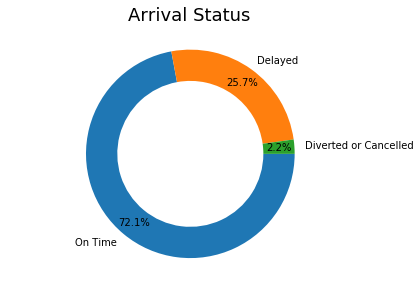

In [46]:

base_color = sns.color_palette()[0]
#sns.palplot(sns.color_palette("Blues"))


# Thanks to https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
#explosion
# explode = []
# for i in range(len(df['ArrStatus_light'].value_counts())):
#     explode.append(0.05)

df['ArrStatus_light'].value_counts().plot.pie(autopct='%1.1f%%',
                                       wedgeprops = {'width' : 0.3},
                                       startangle = 0,
                                       counterclock = False,
                                       pctdistance=0.85);

ax = plt.gca();
ax.set_title('Arrival Status', fontsize=18, y=1.05);
ax.set_ylabel('');
# # Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')  
plt.tight_layout();
# plt.show()

Let's keep only flight and early flight from the dataset.

So we will speed up process time as now we will focus on delayed flights.

In [202]:
#df_late = df.drop(df[df.ArrStatus_light == 'On Time'].index)
df_late = df[df.ArrStatus_light == 'Delayed']

In [48]:
df_late.shape

(1802354, 36)

In [49]:
df[df['ArrDelay'] < -20].shape[0]

378139

## Build methods to draw viz

To be able to explore faster and change all graph in one time, I build method for that.

In [314]:
import matplotlib.patches as mpatches

def comparative_histogram_continuous_variable(column_name, binsize = 100, xlabel=''):
    global df, df_late
    bins = np.arange(df[column_name].min(), df[column_name].max()+binsize, binsize);
    plt.figure(figsize=[13, 5]);
    plt.hist(data = df, x = column_name, bins = bins);
    ax = plt.hist(data = df_late, x = column_name, bins = bins);
    plt.title('Flights count per ' + column_name, fontsize=18);
    xlabel = column_name if xlabel == '' else xlabel
    plt.xlabel(xlabel);
    plt.ylabel('Count');
    blue_patch = mpatches.Patch(color='darkslateblue', label='All')
    red_patch = mpatches.Patch(color='indianred', label='Delayed')
    plt.legend(handles=[blue_patch, red_patch])

def comparative_histogram_categorical_variable(column_name, xlabel=''):
    global df, df_late
    plt.figure(figsize=[13, 5]);
    xlabel = column_name if xlabel == '' else xlabel
    ax1 = sns.countplot(x=column_name, color='darkslateblue', data=df);
    ax2 = sns.countplot(x=column_name, color='indianred', data=df_late);
    plt.title('Flights count per ' + column_name, fontsize=18);
    plt.xlabel(xlabel, labelpad=16);
    plt.ylabel('Count', labelpad=16);
    ax2.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha='right')
    blue_patch = mpatches.Patch(color='darkslateblue', label='All')
    red_patch = mpatches.Patch(color='indianred', label='Delayed')
    plt.legend(handles=[blue_patch, red_patch])

## Check Month

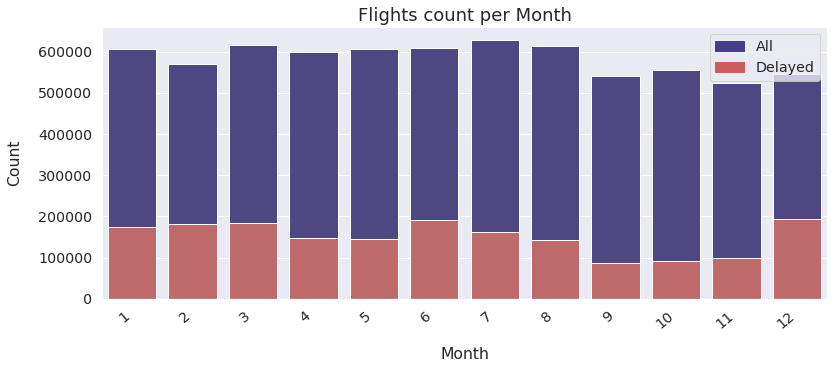

In [315]:
comparative_histogram_categorical_variable('Month');

Flights vary a little bit between month.

It seems to have more delay in December. But it's a count of flights, we will look at it in bi-variate exploration.

## Day of Month

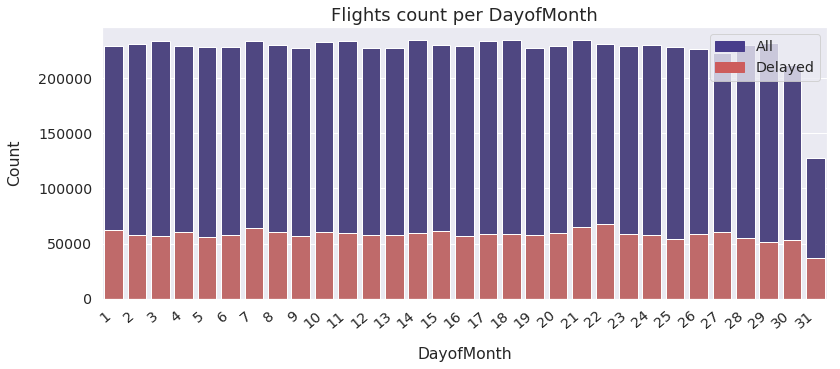

In [316]:
comparative_histogram_categorical_variable('DayofMonth');

We have less count for the 31th day of month. It's normal because not all month has 31 days.

Don't seems to have correlation between Day Of Month and delay. But it's not surprising.

## DayOfWeek

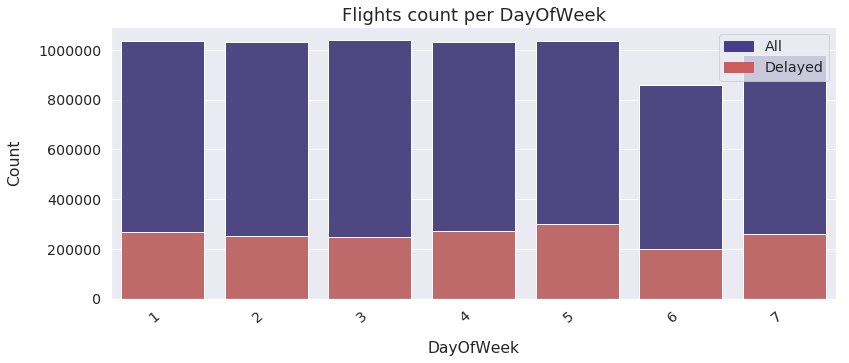

In [317]:
comparative_histogram_categorical_variable('DayOfWeek');

1 is Monday and 7 Sunday.

We saw that there is less flights on Saterday. And it seems to have more delay on Friday.

## Departure Time

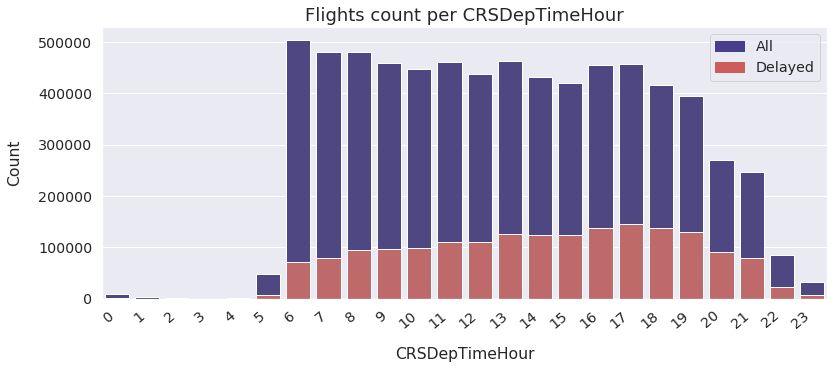

In [318]:
comparative_histogram_categorical_variable('CRSDepTimeHour');

There are more flights at 6 in the morning, but more delay in the evening. It will be interesting to look at this in bi-variate exploration.

## UniqueCarrier

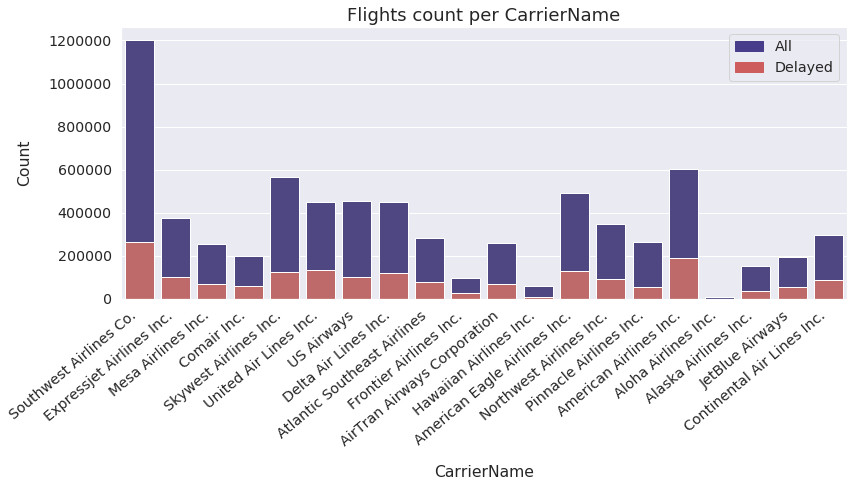

In [319]:
comparative_histogram_categorical_variable('CarrierName')

Here we saw that Southwest airline is the carrier with most flights, far above the others.

And we saw a correlation between carrier and delay : American Airline, despite operating half of Southwest Airline, has almost the same delayed flights.

## CancellationCode

In [294]:
df['CancellationReason'] = df['CancellationCode']

# Thanks to https://stackoverflow.com/questions/48345415/how-to-group-categorical-values-as-a-group-in-pandas
mapping = { 
    'A':'Carrier',
    'B':'Weather',
    'C':'National Air System',
    'D':'Security'
    }

df['CancellationReason'] = df['CancellationReason'].replace(mapping);

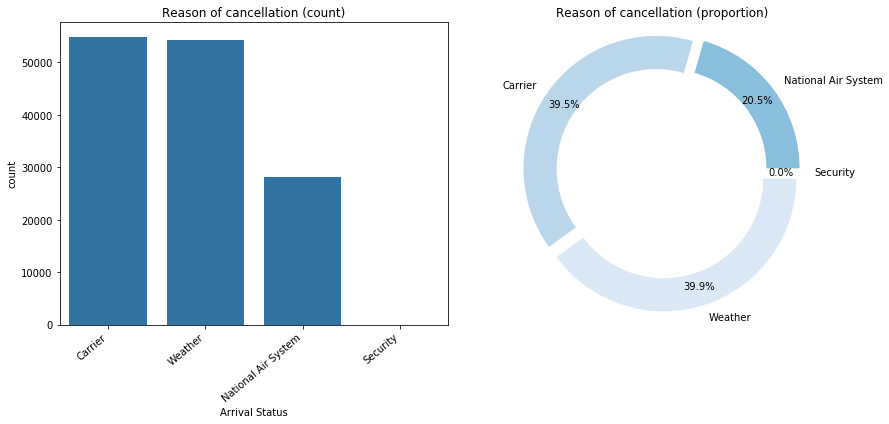

In [60]:
base_color = sns.color_palette()[0]
#sns.palplot(sns.color_palette("Blues"))
cancel_label = ['Carrier', 'Weather','National Air System','Security']
f,ax=plt.subplots(1,2,figsize=(13,6));
axp = sns.countplot('CancellationCode',order = df['CancellationCode'].value_counts().index, data=df,ax=ax[0],
             color = base_color
            );
axp.set_title('Reason of cancellation (count)');
axp.set_xlabel('Arrival Status');
axp.set_xticklabels(cancel_label, rotation=40, ha="right");
#axp.set_xticks(np.arange(len(cancel_label)), cancel_label)

# Thanks to https://medium.com/@kvnamipara/a-better-visualisation-of-pie-charts-by-matplotlib-935b7667d77f
#explosion
explode = []
for i in range(len(df['CancellationCode'].value_counts())):
    explode.append(0.05)

df['CancellationReason'].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[1],
                                       wedgeprops = {'width' : 0.25},
                                       startangle = 0,
                                       counterclock = False,
                                       colors = sns.color_palette("Blues"),
                                       pctdistance=0.85, explode = explode);


ax[1].set_title('Reason of cancellation (proportion)');
ax[1].set_ylabel('');
ax[1].set_xticklabels(cancel_label, rotation=40, ha="right");
# Equal aspect ratio ensures that pie is drawn as a circle
ax[1].axis('equal')  
plt.tight_layout()
plt.show();


## TailNum study

In [61]:
import itertools
vc = df.TailNum.value_counts()
print('Number of flights per airplane :', len(vc))
print('\n10 mosts used airplane')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,10):
      print(name, cnt)

vc = df_late.TailNum.value_counts()
print('Number of fligths by late airplane :', len(vc))
print('\n10 mosts used late airplane')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,10):
      print(name, cnt)

Number of flights per airplane : 5373

10 mosts used airplane
N476HA 4701
N477HA 4548
N484HA 4505
N475HA 4499
N480HA 4416
N481HA 4373
N478HA 4317
N485HA 4309
N479HA 4268
N486HA 4246
Number of fligths by late airplane : 5355

10 mosts used late airplane
N77278 928
N87353 885
N37342 874
N27318 837
N17175 832
N77302 820
N37208 818
N651ML 779
N570ML 777
N27172 776


## FlightNum

In [62]:
import itertools
vc = df.FlightNum.value_counts()
print('Number of distinct FlightNum :', len(vc))
print('\n10 mosts used airplane')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,10):
      print(name, cnt)

vc = df_late.FlightNum.value_counts()
print('Number of distinct FlightNum :', len(vc))
print('\n10 mosts late FlightNum')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,10):
      print(name, cnt)

Number of distinct FlightNum : 7539

10 mosts used airplane
152 4883
12 4793
16 4717
511 4621
308 4449
73 4330
623 4262
321 4234
197 4190
15 4189
Number of distinct FlightNum : 7503

10 mosts late FlightNum
16 1445
50 1395
15 1364
321 1340
75 1338
701 1298
12 1285
40 1267
44 1240
511 1231


The flight "357" is the most often late flight in 2006, but it's also the one that flight often : 5 093 flights in 2006 only.

We have to compute a ratio between number of delayed flights vs total flights.

## 'Origin'

In [63]:
import itertools
vc = df.OriginCity.value_counts()
print('Number of Origin airport :', len(vc))
print('\n10 mosts used origin airport')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,10):
      print(name, cnt)

Number of Origin airport : 288

10 mosts used origin airport
Chicago 437999
Atlanta 414513
Dallas-Fort Worth 281281
Denver 241443
Houston 241105
New York 237939
Los Angeles 215608
Phoenix 199408
Las Vegas 172876
Detroit 161989


## Destination

In [64]:
import itertools
vc = df.DestCity.value_counts()
print('Number of Dest airport :', len(vc))
print('\n10 mosts used Dest airport')
# Thanks to https://stackoverflow.com/questions/36106712/how-can-i-limit-iterations-of-a-loop-in-python
for name, cnt in itertools.islice(vc.iteritems(),0,10):
      print(name, cnt)

Number of Dest airport : 289

10 mosts used Dest airport
Chicago 438052
Atlanta 414521
Dallas-Fort Worth 281401
Denver 241470
Houston 241094
New York 237919
Los Angeles 215685
Phoenix 199416
Las Vegas 172871
Detroit 162000


## Distance

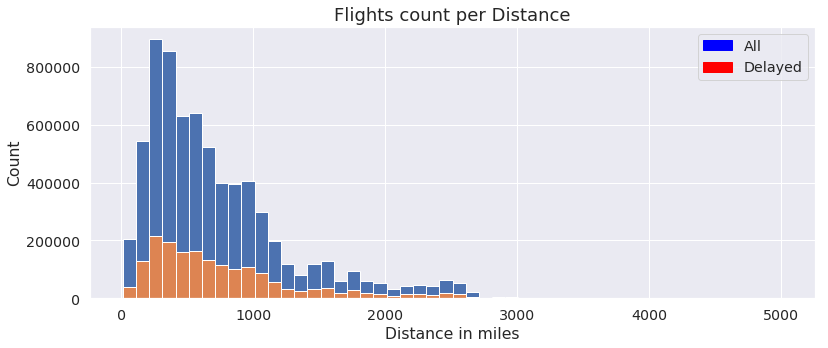

In [297]:
comparative_histogram_continuous_variable('Distance', xlabel='Distance in miles')

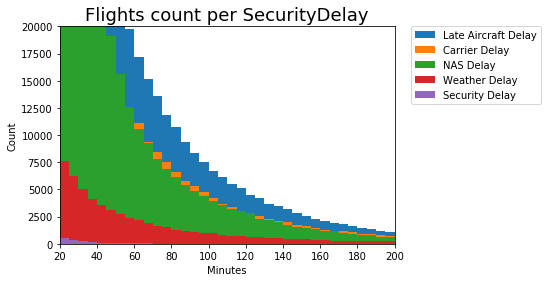

In [66]:
reasons = ['LateAircraftDelay', 'CarrierDelay', 'NASDelay', 'WeatherDelay', 'SecurityDelay' ]

def histogram_continuous_variable(column_name, binsize = 100, legend=''):
    bins = np.arange(df[column_name].min(), df[column_name].max()+binsize, binsize);
    #plt.figure(figsize=[8, 5]);
    plt.hist(data = df_late, x = column_name, bins = bins, label=legend);
    plt.title('Flights count per ' + column_name, fontsize=18);
    legend = column_name if legend == '' else legend
    plt.xlabel('Minutes');
    plt.ylabel('Count');
    plt.xlim([20,200]);
    plt.ylim([0,20000]);
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.show;


histogram_continuous_variable('LateAircraftDelay', binsize=5, legend='Late Aircraft Delay')

histogram_continuous_variable('CarrierDelay', binsize=5, legend='Carrier Delay')
histogram_continuous_variable('NASDelay', binsize=5, legend='NAS Delay')
histogram_continuous_variable('WeatherDelay', binsize=5, legend='Weather Delay')

histogram_continuous_variable('SecurityDelay', binsize=5, legend='Security Delay')
plt.show;

# import matplotlib.patches as mpatches
# red_patch = mpatches.Patch(color='blue', label='Late Aircraft Delay')
# red_patch = mpatches.Patch(color='orange', label='NAS Delay')
# red_patch = mpatches.Patch(color='green', label='Weather Delay')
# red_patch = mpatches.Patch(color='red', label='Security Delay')
# plt.legend(handles=[red_patch]);


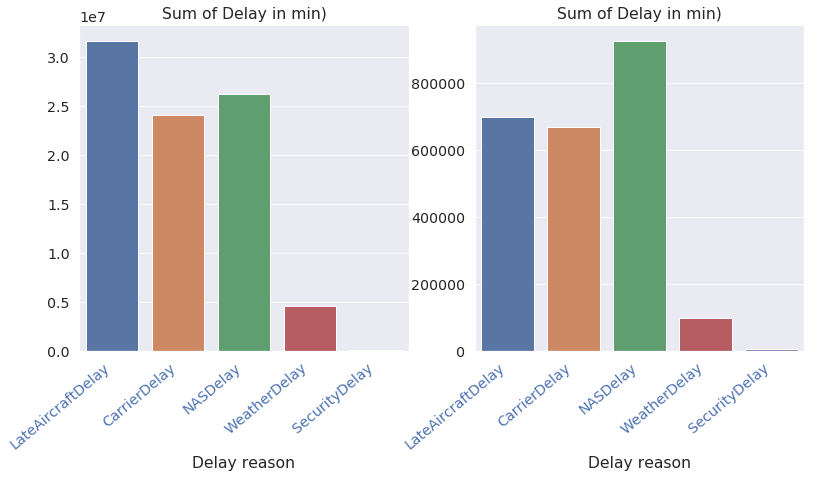

In [165]:

name = []
sum_delay = []
num_delay = []
for reason in reasons:
    name.append(reason)
    sum_delay.append(df_late[reason].sum())
    num_delay.append(
        len( df_late.query(reason + " > 0") )
    )

fig,ax=plt.subplots(1,2,figsize=(13,6));
sns.barplot(x=name, y=sum_delay, ax=ax[0]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right", color = base_color)
ax[0].set_title('Sum of Delay in min)');
ax[0].set_xlabel('Delay reason');
sns.barplot(x=name, y=num_delay, ax=ax[1]);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right", color = base_color)
ax[1].set_title('Sum of Delay in min)');
ax[1].set_xlabel('Delay reason');
#plt.show();

https://aspmhelp.faa.gov/index.php/Types_of_Delay


**Carrier Delay** is within the control of the air carrier. Examples of occurrences that may determine carrier delay are: aircraft cleaning, aircraft damage, awaiting the arrival of connecting passengers or crew, baggage, bird strike, cargo loading, catering, computer, outage-carrier equipment, crew legality (pilot or attendant rest), damage by hazardous goods, engineering inspection, fueling, handling disabled passengers, late crew, lavatory servicing, maintenance, oversales, potable water servicing, removal of unruly passenger, slow boarding or seating, stowing carry-on baggage, weight and balance delays.


**Late Arrival Delay** at an airport due to the late arrival of the same aircraft at a previous airport. The ripple effect of an earlier delay at downstream airports is referred to as delay propagation.


**NAS Delay** is within the control of the National Airspace System (NAS) may include: non-extreme weather conditions, airport operations, heavy traffic volume, air traffic control, etc. Delays that occur after Actual Gate Out are usually attributed to the NAS and are also reported through OPSNET.


**Security delay** is caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.


**Weather delay** is caused by extreme or hazardous weather conditions that are forecasted or manifest themselves on point of departure, enroute, or on point of arrival. 

In [68]:
df_late.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime', 'ArrTime',
       'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'Cancelled',
       'CancellationCode', 'Diverted', 'CarrierDelay', 'WeatherDelay',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'OriginCity',
       'OriginState', 'OriginLat', 'OriginLong', 'DestCity', 'DestState',
       'DestLat', 'DestLong', 'CarrierName', 'OriginStateName',
       'DestStateName', 'ArrStatus', 'ArrStatus_light'],
      dtype='object')

In [69]:
df_late.drop(['DepTime', 'ArrTime', 'CRSArrTime', 'DepDelay', ], axis=1, inplace=True)

/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [70]:
df_late.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'UniqueCarrier',
       'FlightNum', 'TailNum', 'ArrDelay', 'Origin', 'Dest', 'Distance',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'OriginCity', 'OriginState', 'OriginLat', 'OriginLong', 'DestCity',
       'DestState', 'DestLat', 'DestLong', 'CarrierName', 'OriginStateName',
       'DestStateName', 'ArrStatus', 'ArrStatus_light'],
      dtype='object')

In [71]:
df_late[['TailNum', 'ArrDelay', 'CancellationCode', 'Diverted', 'CarrierDelay', 'LateAircraftDelay', 'NASDelay', 'WeatherDelay', 'SecurityDelay']].head(3)

,TailNum,ArrDelay,CancellationCode,Diverted,CarrierDelay,LateAircraftDelay,NASDelay,WeatherDelay,SecurityDelay
2,N428WN,14.0,NaN,0,NaN,NaN,NaN,NaN,NaN
4,N464WN,34.0,NaN,0,2.0,32.0,0.0,0.0,0.0
5,N726SW,11.0,NaN,0,NaN,NaN,NaN,NaN,NaN


In [72]:
#df.plot.bar(x='Cancelled', y='Month', rot=0)

In [73]:

# min_delay = 1000
# #df_hight_delay = df[np.isfinite(df['Cancelled'])].query("ArrDelay > @min_delay")

# # start with a standard-scaled plot
# binsize = 100
# bins = np.arange(min_delay, df_hight_delay['ArrDelay'].max()+binsize, binsize);
# plt.figure(figsize=[8, 5]);
# plt.hist(data = df_hight_delay, x = 'ArrDelay', bins = bins);
# plt.xlabel('ArrDelay (min)');
# plt.show();


In [74]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde');

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!
The ArrDelay seems clean and tidy



### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

To compare delay by Airport we have to compute a new feature that divide delay by number of flights

We could also compute a new feature by computing delay category : low, medium, high and canceled.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

In [75]:
df_late.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'UniqueCarrier',
       'FlightNum', 'TailNum', 'ArrDelay', 'Origin', 'Dest', 'Distance',
       'Cancelled', 'CancellationCode', 'Diverted', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'OriginCity', 'OriginState', 'OriginLat', 'OriginLong', 'DestCity',
       'DestState', 'DestLat', 'DestLong', 'CarrierName', 'OriginStateName',
       'DestStateName', 'ArrStatus', 'ArrStatus_light'],
      dtype='object')

In [76]:
correlation_matrix = df_late[['ArrDelay', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest',
       'Distance']].corr()

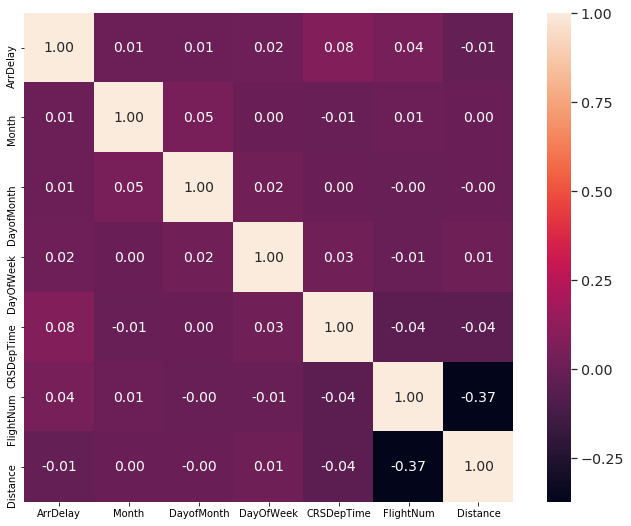

In [77]:
_ = plt.subplots(figsize=(12, 9));
sns.set(font_scale=1.3)
hm = sns.heatmap(correlation_matrix, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 14})
plt.show()

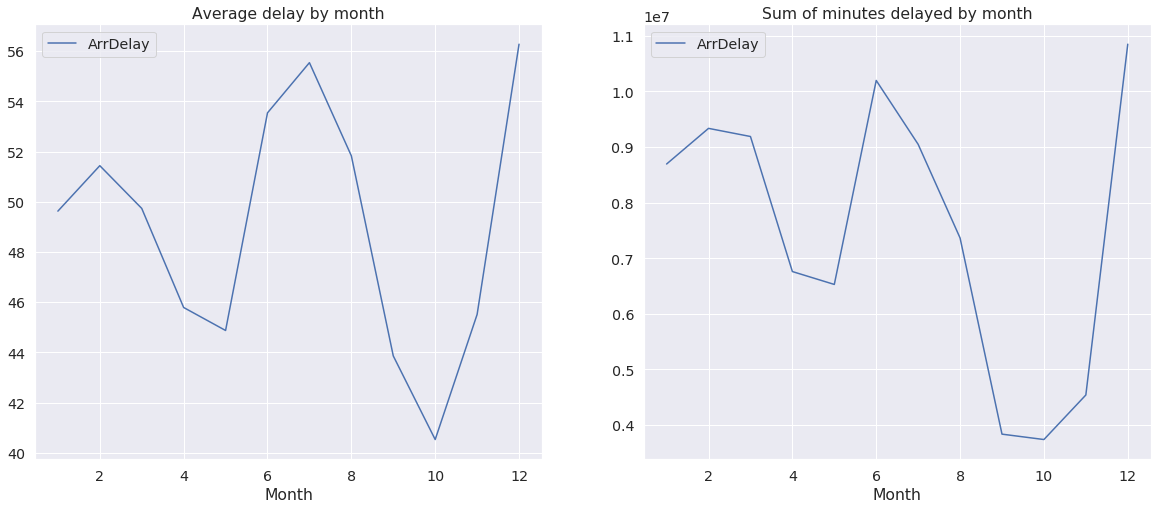

In [78]:
f,ax=plt.subplots(1,2,figsize=(20,8));
df_late[['Month','ArrDelay']].groupby(['Month']).mean().plot(ax=ax[0]);
ax[0].set_title('Average delay by month');
df_late[['Month','ArrDelay']].groupby(['Month']).sum().plot(ax=ax[1]);
ax[1].set_title('Sum of minutes delayed by month');
plt.show();

In [79]:
# Thanks to https://stackoverflow.com/questions/32633977/how-to-create-categorical-variable-based-on-a-numerical-variable

def create_season(df):
    # Set the categorical variable values
    season = ['Spring', 'Summer', 'Fall', 'Winter', 'Unknown']
    # Set default value
    df['Season'] = 'Unknown';
    _ = pd.Categorical(df.Season, categories=season, ordered=True);

    df.loc[(df['Month'] == 3) , 'Season'] = 'Spring'
    df.loc[(df['Month'] == 4) , 'Season'] = 'Spring'
    df.loc[(df['Month'] == 5) , 'Season'] = 'Spring'

    df.loc[(df['Month'] == 6) , 'Season'] = 'Summer'
    df.loc[(df['Month'] == 7) , 'Season'] = 'Summer'
    df.loc[(df['Month'] == 8) , 'Season'] = 'Summer'

    df.loc[(df['Month'] == 9) , 'Season'] = 'Fall'
    df.loc[(df['Month'] == 10) , 'Season'] = 'Fall'
    df.loc[(df['Month'] == 11) , 'Season'] = 'Fall'

    df.loc[(df['Month'] == 12) , 'Season'] = 'Winter'
    df.loc[(df['Month'] == 1) , 'Season'] = 'Winter'
    df.loc[(df['Month'] == 2) , 'Season'] = 'Winter'

create_season(df);
create_season(df_late);
df['Season'].value_counts();
df_late['Season'].value_counts();

/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


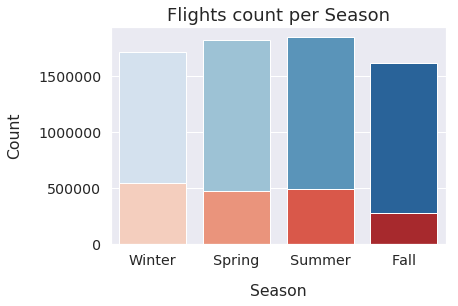

In [80]:
comparative_histogram_categorical_variable('Season')

/media/data-nvme/dev/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


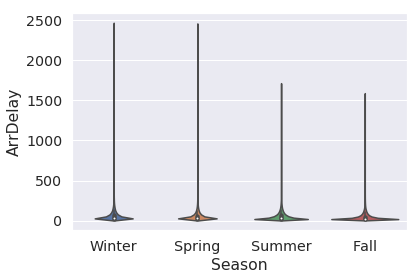

In [81]:
sns.violinplot(data = df_late, x = 'Season', y = 'ArrDelay');

We can't see nothing with default parameters.

Let's keep only delay between 10 minutes and 100 minutes.

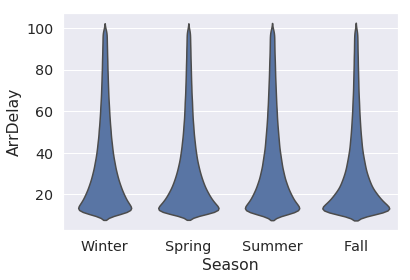

In [82]:
base_color = sns.color_palette()[0]
sns.violinplot(data = df_late.query("ArrDelay > 10 and ArrDelay < 100"), x = 'Season', y = 'ArrDelay', color = base_color,
              inner = None);

We don't see much more info, let's switch to WeatherDelay instead of ArrDelay.

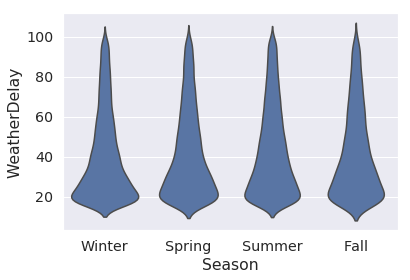

In [83]:
base_color = sns.color_palette()[0]

sns.violinplot(data = df_late.query("WeatherDelay > 15 and WeatherDelay < 100"), x = 'Season', y = 'WeatherDelay', color = base_color,
              inner = None);

We don't see much more info, let's switch to a boxplot.

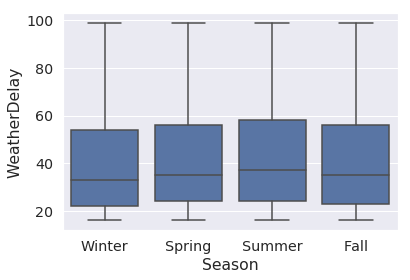

In [84]:
base_color = sns.color_palette()[0]

sns.boxplot(data = df_late.query("WeatherDelay > 15 and WeatherDelay < 100"), x = 'Season',
            y = 'WeatherDelay', color = base_color, showfliers=False);

Here we see a correlation. Being french I was expected to have more delay in Winter, due to snow, but it's in Summer and Fall.

I have forgotten that there are hurricanes in US in theses season.

And airplane are very impacted by hurricane.

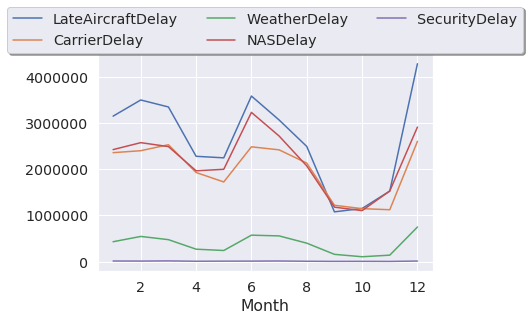

In [85]:
ax = df_late.groupby('Month')['LateAircraftDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay'].sum().plot();
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3, fancybox=True, shadow=True);
plt.show()

In [86]:
df_late[['Season','WeatherDelay']].groupby(['Season']).mean().head(4)

,WeatherDelay
Season,
Fall,1.772230
Spring,2.460826
Summer,3.593607
Winter,3.635520


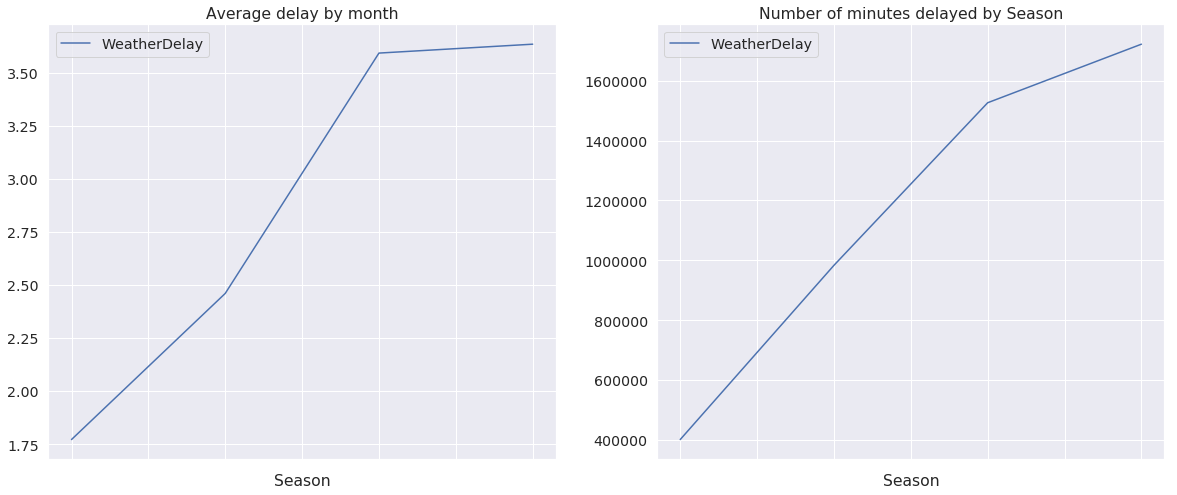

In [87]:
f,ax=plt.subplots(1,2,figsize=(20,8));
df_late[['Season','WeatherDelay']].groupby(['Season']).mean().plot(ax=ax[0]);
ax[0].set_title('Average delay by month');
df_late[['Season','WeatherDelay']].groupby(['Season']).sum().plot(ax=ax[1]);
ax[1].set_title('Number of minutes delayed by Season');
plt.show();

## Distance

In [203]:
df_sample = df_late.sample(frac=0.1, replace=False, random_state=1).query("ArrDelay > 10 and ArrDelay < 500 and Distance < 2000")
pv('df_sample.shape')

df_sample.shape : (170789, 39)


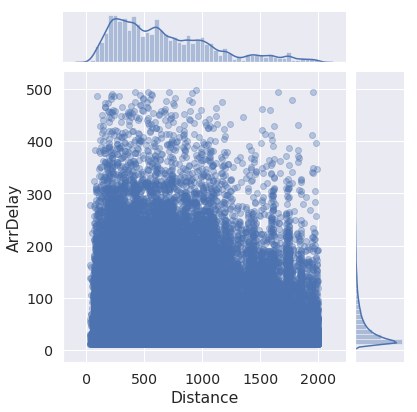

In [89]:
sns.jointplot(x='Distance',y='ArrDelay',data=df_sample,kind='reg', fit_reg = False,
             x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/3});
plt.show();

## City and Carrier

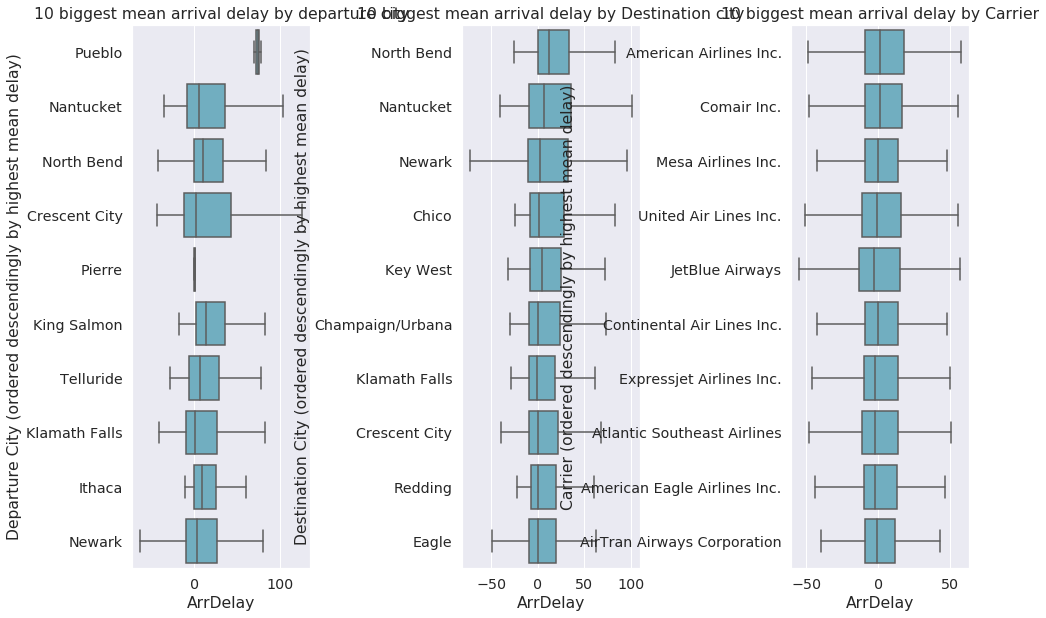

In [90]:
plt.figure(figsize = [15, 10])
plt.subplots_adjust(wspace = 0.85) # adjust spacing between subplots, in order to show long country names nicely
plt.subplot(1, 3, 1)
delay_city_order = df.groupby('OriginCity')['ArrDelay'].mean().sort_values(ascending = False).index[:10]

sns.boxplot(x = df['ArrDelay'], y = df['OriginCity'], order = delay_city_order,
            color = sns.color_palette()[9], showfliers=False);
plt.ylabel('Departure City (ordered descendingly by highest mean delay)')
plt.title('10 biggest mean arrival delay by departure city');

plt.subplot(1, 3, 2)
delay_city_order = df.groupby('DestCity')['ArrDelay'].mean().sort_values(ascending = False).index[:10]

sns.boxplot(x = df['ArrDelay'], y = df['DestCity'], order = delay_city_order,
            color = sns.color_palette()[9], showfliers=False);
plt.ylabel('Destination City (ordered descendingly by highest mean delay)')
plt.title('10 biggest mean arrival delay by Destination city');

plt.subplot(1, 3, 3)
delay_carrier_order = df.groupby('CarrierName')['ArrDelay'].mean().sort_values(ascending = False).index[:10]

sns.boxplot(x = df['ArrDelay'], y = df['CarrierName'], order = delay_carrier_order,
            color = sns.color_palette()[9], showfliers=False);
plt.ylabel('Carrier (ordered descendingly by highest mean delay)')
plt.title('10 biggest mean arrival delay by Carrier');




## TailNum

In [91]:
df_late_TailNum = df_late.groupby(['TailNum'])['ArrDelay'].mean().reset_index();

In [92]:
df_late_TailNum.head(3)

,TailNum,ArrDelay
0,80009E,47.799517
1,80019E,44.031915
2,80059E,51.293011


### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

# Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

In [94]:
#df_sample[['OriginCity', 'Season', 'ArrDelay']]
#df_orig_season_delay.info()

## Delay by City and  Season

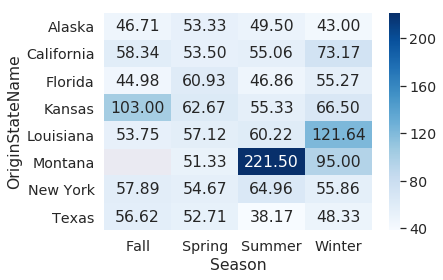

In [100]:

df_orig_season_delay = df_sample[['OriginStateName', 'Season', 'WeatherDelay']]
df_orig_season_delay = df_orig_season_delay.query("WeatherDelay > 10 \
    and OriginStateName in ('Texas', 'California', 'Alaska', 'Florida', 'Kansas', 'New York', 'Louisiana', 'Montana' )")
df_orig_season_delay.dropna(inplace=True)
df_orig_season_delay = df_orig_season_delay.groupby(['OriginStateName', 'Season'])['WeatherDelay'].mean().reset_index();


data_pivoted = df_orig_season_delay.pivot('OriginStateName', 'Season', 'WeatherDelay')
heat_map = sns.heatmap(data_pivoted, cmap = 'Blues', annot=True, fmt='.2f')

# _ = plt.subplots(figsize=(12, 9));
# sns.set(font_scale=1.3)
# hm = sns.heatmap(correlation_matrix, cbar=True, annot=True, square=True, fmt='.2f',
#                  annot_kws={'size': 14})

In [ ]:
#!pip install geopandas descartes

## Map of delay

In [147]:
import geopandas as gpd

df_orig_season_delay_geo = df_sample.query("Season == 'Winter'")[['OriginState', 'OriginStateName', 'Season', 'WeatherDelay']] # WeatherDelay > 10 and 

df_orig_season_delay_geo.dropna(inplace=True)
df_orig_season_delay_geo = df_orig_season_delay_geo.groupby(['OriginStateName', 'OriginState'])['WeatherDelay'].mean().reset_index();
df_orig_season_delay_geo.head(3)

,OriginStateName,OriginState,WeatherDelay
0,Alabama,AL,4.860000
1,Alaska,AK,2.989071
2,Arizona,AZ,1.462541


In [155]:

# You have to downlaod and unzip https://www2.census.gov/geo/tiger/GENZ2017/shp/cb_2017_us_state_20m.zip
# To get the 

shape = "./cb_2017_us_state_20m/cb_2017_us_state_20m.shp"
usa_map = gpd.read_file(shape)

#usa_map.head(3)

df_map = usa_map.merge(df_orig_season_delay_geo, how='left', left_on='NAME', right_on='OriginStateName')
#df_map.head()

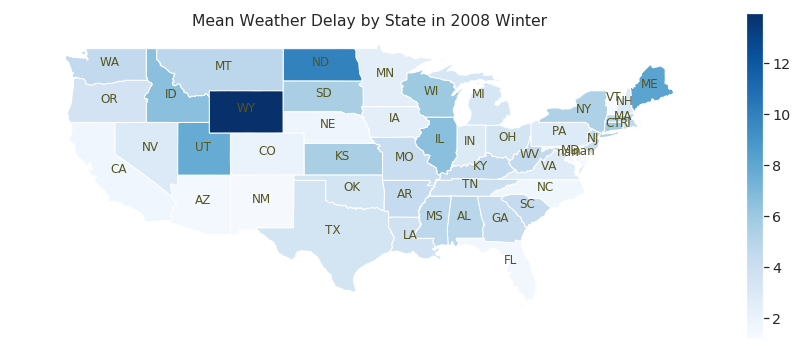

In [161]:
# Thanks to https://github.com/bendoesdata/make-a-map-geopandas
figsize = (15, 6)
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_title('Mean Weather Delay by State in 2008 Winter')
# Zoom to US only, without Alaska and Hawai
df_non_alaska = df_map.cx[-120:-65, 20:80]
# Draw the map
df_non_alaska.plot(column='WeatherDelay', ax=ax, cmap='Blues', k=num_colors, legend=True);
# thanks to https://stackoverflow.com/questions/38899190/geopandas-label-polygons
df_non_alaska.apply(lambda x: ax.annotate(s=x.OriginState, xy=x.geometry.centroid.coords[0],
           fontsize=12, ha='center', color='#555520'),axis=1);
# remove the axis
ax.axis('off');

In [ ]:

df_orig_season_delay = df_sample[['OriginCity', 'Season', 'ArrDelay']]
df_orig_season_delay.dropna(inplace=True)

# Compute Hours of day

# Compute 

# Weekday order
# weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# df_cleaned['start_time_weekday'] = pd.Categorical(df_cleaned['start_time_weekday'], categories= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True);

#plt.figure(figsize=(15,8))

# Heatmap - Customers
#plt.subplot(1, 2, 1)
# df_customer = df_cleaned.query('user_type == "Customer"').groupby(['start_time_hour', 'start_time_weekday'])['bike_id'].size().reset_index();
# df_customer = df_customer.pivot('start_time_hour', 'start_time_weekday', 'bike_id')
data_pivoted = df_orig_season_delay.pivot('OriginCity', 'Season', 'ArrDelay')
heat_map = sns.heatmap(data_pivoted, cmap = 'twilight')

plt.title('Day of week and DepTime and Delay', y=1.05);
plt.xlabel('Weekday', labelpad = 16);
plt.ylabel('Start Time Hour',  labelpad = 16);

plt.show()

#graph.suptitle('Ford GoBike System - Start Time vs. Weekday by User Type', y = 1.05, fontsize = 16, fontweight = 'bold');

In [ ]:
data_pivoted

## Delay by Carrier by City

## Day of week and DepTime and Delay

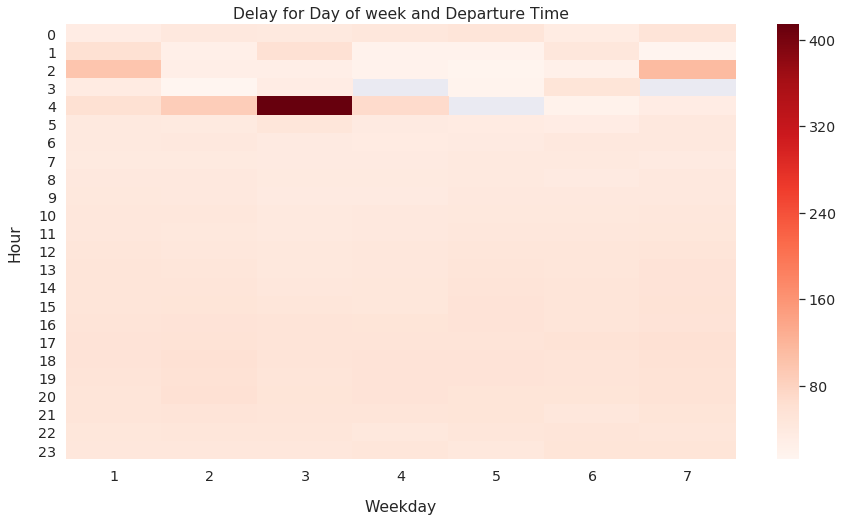

In [220]:
plt.figure(figsize=(15,8))
df_group = df_late.groupby(['CRSDepTimeHour', 'DayOfWeek'])['ArrDelay'].mean().reset_index();
df_pivot = df_sample_group.pivot('CRSDepTimeHour', 'DayOfWeek', 'ArrDelay');

heat_map = sns.heatmap(df_pivot, cmap = 'Reds');

plt.title('Delay for Day of week and Departure Time', y=1.05);
plt.xlabel('Weekday', labelpad = 16);
plt.ylabel('Hour',  labelpad = 16);

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

In [ ]:

plt.figure(figsize=(13,5));
sns.boxplot(x='ArrDelay', data=df[df['ArrDelay'] > 500], palette='Reds', orient='h');
plt.title("The delay distribution of flights", fontsize=18, y=1.05);
plt.xlabel("Arrival delay", fontsize=15, labelpad=5);


In [ ]:
# Note :
#     https://blog.hugo-larcher.com/flight-data-visualisation-with-pandas-and-matplotlib-ebbd13038647 : Affichage des trajets des avions.
#             => Flight with most delay for exemple.
           
# Affichage de ville sur la carte :
# https://gis.stackexchange.com/questions/198530/plotting-us-cities-on-a-map-with-matplotlib-and-basemap
# /!\ Nécessite Basemap, qui ne s'intalle pas faccilement avec Pip :(